In [1]:
% matplotlib inline 

import nibabel as nib
import nibabel.gifti
import nilearn
from nilearn import datasets, plotting
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
mpl.rcParams['svg.fonttype'] = 'none'

import sys
sys.path.append('gradient_data/src/')
from viz import *

import surfdist as sd
from surfdist import viz, load, utils, surfdist

/Applications/miniconda3/envs/topography/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Applications/miniconda3/envs/topography/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def imageCrop(filename):

    from PIL import Image

    i1 = Image.open(filename)
    i2 = np.array(i1)
    i2[i2.sum(axis=2) == 255*4,:] = 0
    i3 = i2.sum(axis=2)
    x = np.where((i3.sum(axis=1) != 0) * 1)[0]
    y = np.where((i3.sum(axis=0) != 0) * 1)[0]

    result = Image.fromarray(i2[x.squeeze()][:,y.squeeze()])
    result.save(filename)

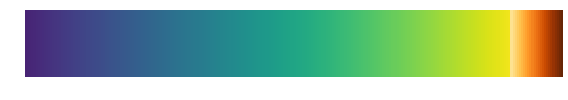

In [3]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('nipy_spectral')
new_cmap = truncate_colormap(cmap, 0.2, 0.95)

#colors1 = plt.cm.YlGnBu(np.linspace(0, 1, 128))
first = int((128*2)-np.round(255*(1.-0.90)))
second = (256-first)
#colors2 = new_cmap(np.linspace(0, 1, first))
colors2 = plt.cm.viridis(np.linspace(0.1, .98, first))
colors3 = plt.cm.YlOrBr(np.linspace(0.25, 1, second))
colors4 = plt.cm.PuBu(np.linspace(0., 0.5, second))
#colors4 = plt.cm.pink(np.linspace(0.9, 1., second))
# combine them and build a new colormap
cols = np.vstack((colors2,colors3))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', cols)

num = 256
gradient = range(num)
for x in range(5):
    gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(nrows=1)
ax.imshow(gradient, cmap=mymap, interpolation='nearest')
ax.set_axis_off()
fig.tight_layout()

plt.show()

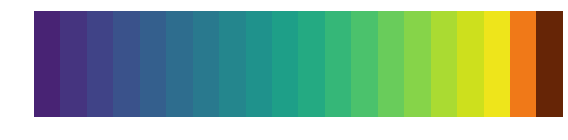

In [18]:
num = 20
gradient = range(num)
for x in range(2):
    gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(nrows=1)
ax.imshow(gradient, cmap=mymap, interpolation='nearest')
ax.set_axis_off()
fig.tight_layout()

plt.show()

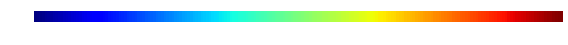

In [10]:
num = 200
gradient = range(num)
for x in range(2):
    gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(nrows=1)
ax.imshow(gradient, cmap='jet', interpolation='nearest')
ax.set_axis_off()
fig.tight_layout()

plt.show()

# Geodesic distance from gradient peaks

In [3]:
import h5py, sys, io, numpy as np
import nibabel as nib 

surfmL = nib.freesurfer.read_geometry('gradient_data/templates/S900.L.midthickness_MSMAll.32k_fs_LR.surf')
surfiL = nib.freesurfer.read_geometry('gradient_data/templates/S900.L.very_inflated_MSMAll.32k_fs_LR.surf')
surfL = []
surfL.append(np.array(surfmL[0]*0.3 + surfiL[0]*0.7))
surfL.append(surfmL[1])

surfmR = nib.freesurfer.read_geometry('gradient_data/templates/S900.R.midthickness_MSMAll.32k_fs_LR.surf')
surfiR = nib.freesurfer.read_geometry('gradient_data/templates/S900.R.very_inflated_MSMAll.32k_fs_LR.surf')
surfR = []
surfR.append(np.array(surfmR[0]*0.3 + surfiR[0]*0.7))
surfR.append(surfmR[1])

sulcL = -1 * nib.load('gradient_data/templates/Q1-Q6_R440.sulc.32k_fs_LR.dscalar.nii').data[0:32492]
sulcR = -1 * nib.load('gradient_data/templates/Q1-Q6_R440.sulc.32k_fs_LR.dscalar.nii').data[32492:32492*2]

res = nib.load('gradient_data/templates/hcp.tmp.lh.dscalar.nii').data
cortL = np.squeeze(np.array(np.where(res != 0)[0], dtype=np.int32))
res = nib.load('gradient_data/templates/hcp.tmp.rh.dscalar.nii').data
cortR = np.squeeze(np.array(np.where(res != 0)[0], dtype=np.int32))
cortLen = len(cortL) + len(cortR)
del res

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [4]:
surffL = nib.freesurfer.read_geometry('gradient_data/templates/S900.L.flat.32k_fs_LR.surf')
surffR = nib.freesurfer.read_geometry('gradient_data/templates/S900.R.flat.32k_fs_LR.surf')

In [5]:
sns.set(style="white", color_codes=True)

def doDist(points, surf, cort, sulc, plotDist=None, zones=None, plots=None, output_file=None, showall=None):
    if len(np.shape(points)) > 1:
        dist = surfdist.dist_calc(surf, np.squeeze(cort), [np.concatenate(points)])
    else:
        dist = surfdist.dist_calc(surf, np.squeeze(cort), points)
    count=0
    if plotDist:
        f = plot_surf_stat_map(surf[0], surf[1], bg_map=sulc, mask=cort, bg_on_stat=True, stat_map=(dist-dist.mean()) * -1, azim=0, alpha=1, symmetric_cbar=None)
        plt.show()
        if output_file:            
            f.savefig(('Fig.%s' % str(count)) + output_file)
            count =+ 1
        f = plot_surf_stat_map(surf[0], surf[1], bg_map=sulc, mask=cort, bg_on_stat=True, stat_map=(dist-dist.mean()) * -1, azim=180, alpha=1, symmetric_cbar=None)
        plt.show()
        if output_file:            
            f.savefig(('Fig.%s' % str(count)) + output_file)
            count =+ 1

    if zones:
        dist_vals = np.zeros((len(points), len(surf[0])))
        for n, p in enumerate(points):    
            dist_vals[n, :] = surfdist.dist_calc(surf, np.squeeze(cort), [p])
            print n
        zone = (np.argsort(dist_vals, axis=0)[0, :] + 1.) / len(points)
        zone = zone - np.mean(zone)
        
        aZ = []
        z0 = zone[surfR[1]][:,0]
        z1 = zone[surfR[1]][:,1]
        z2 = zone[surfR[1]][:,2]

        for n,i in enumerate(z0):
            if i != z1[n]:
                aZ.append(surfR[1][n])
            if i != z2[n]:
                aZ.append(surfR[1][n])
            if z1[n] != z2[n]:
                aZ.append(surfR[1][n])

        aZ = np.unique(aZ)
        
        f = plot_surf_stat_map(surf[0], surf[1], bg_map=sulc, stat_map=dist-dist.mean(), mask=np.setdiff1d(cort, aZ), bg_on_stat=True, azim=0, lenient=True)
        plt.show()
        if output_file:            
            f.savefig(('Fig.%s' % str(count)) + output_file)
            count =+ 1
        f = plot_surf_stat_map(surf[0], surf[1], bg_map=sulc, stat_map=dist-dist.mean(), mask=np.setdiff1d(cort, aZ), bg_on_stat=True, azim=180, lenient=True)
        plt.show()
        if output_file:            
            f.savefig(('Fig.%s' % str(count)) + output_file)
            count =+ 1
        if showall:
            f = plot_surf_stat_map(surf[0], surf[1], bg_map=sulc, stat_map=dist-dist.mean(), mask=np.setdiff1d(cort, aZ), bg_on_stat=True, azim=90, lenient=True)
            plt.show()
            if output_file:            
                f.savefig(('Fig.%s' % str(count)) + output_file)
                count =+ 1
            f = plot_surf_stat_map(surf[0], surf[1], bg_map=sulc, stat_map=dist-dist.mean(), mask=np.setdiff1d(cort, aZ), bg_on_stat=True, azim=270, lenient=True)
            plt.show()
            if output_file:            
                f.savefig(('Fig.%s' % str(count)) + output_file)
                count =+ 1
            f = plot_surf_stat_map(surf[0], surf[1], bg_map=sulc, stat_map=dist-dist.mean(), mask=np.setdiff1d(cort, aZ), bg_on_stat=True, elev=90, lenient=True)
            plt.show()
            if output_file:            
                f.savefig(('Fig.%s' % str(count)) + output_file)
                count =+ 1
            f = plot_surf_stat_map(surf[0], surf[1], bg_map=sulc, stat_map=dist-dist.mean(), mask=np.setdiff1d(cort, aZ), bg_on_stat=True, elev=270, lenient=True)
            plt.show()
            if output_file:            
                f.savefig(('Fig.%s' % str(count)) + output_file)
                count =+ 1
            
    if plots != None:
        incld = np.where(dist[cort] != 0)[0]
        comp = {'dist':dist[cort][incld], 'embed':plots[incld]}
        g = sns.jointplot(x='dist', y='embed', data=comp, kind="hex").set_axis_labels("dist", "gradient")
        if output_file:            
            g.savefig(('Fig.%s' % str(count)) + output_file + '.pdf')
            count =+ 1

    
            
    return dist

def rmPoints(pts, rmPts):
    pts = list(pts)
    pts.remove(rmPts)
    pts = np.squeeze(np.array(pts, dtype=np.int32))
    return pts

def getClusts(surf,cort,thr, embVals, side='Top'):

    import networkx as nx
    from scipy import stats
    
    thr = np.percentile(embVals,thr)
    # binned = stats.rankdata(embVals, "average")/len(cort)
    data = np.zeros(len(surf[0]))
    data[cort] = embVals
    
    G=nx.Graph()
    G.add_nodes_from(range(len(surf[0])))
    G.add_edges_from(surf[1][:,[0,1]])
    G.add_edges_from(surf[1][:,[0,2]])
    G.add_edges_from(surf[1][:,[1,2]])

    if side == 'Top':
        clustgraph = nx.subgraph(G, np.where(data >= thr)[0])
    if side == 'Bottom':
        clustgraph = nx.subgraph(G, np.where(data <= thr)[0])        
        
    subclust = sorted(nx.connected_components(clustgraph), key = len, reverse=True)

    subclust2 = []
    for n, p in enumerate(subclust):
        subclust2.append(np.array(list(p)))
    print len(subclust2)

    return subclust2



In [6]:
# Load embedding results
emb = np.load('gradient_data/embedded/embedding_dense_emb.npy')

dataL = np.zeros((len(surfL[0]), emb.shape[1]))
dataL[cortL,:] = emb[0:len(cortL),:]
dataR = np.zeros((len(surfR[0]), emb.shape[1]))
dataR[cortR,:] = emb[len(cortL):cortLen,:]

70
9


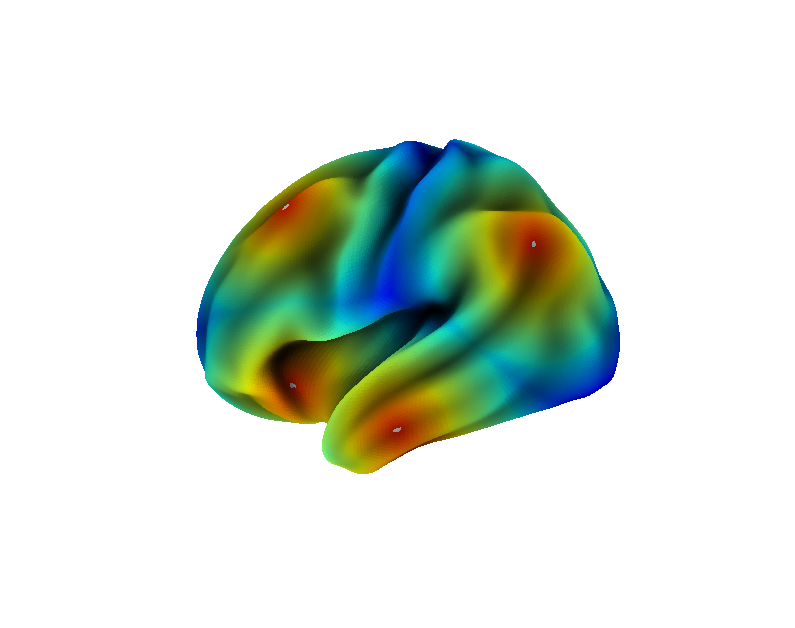

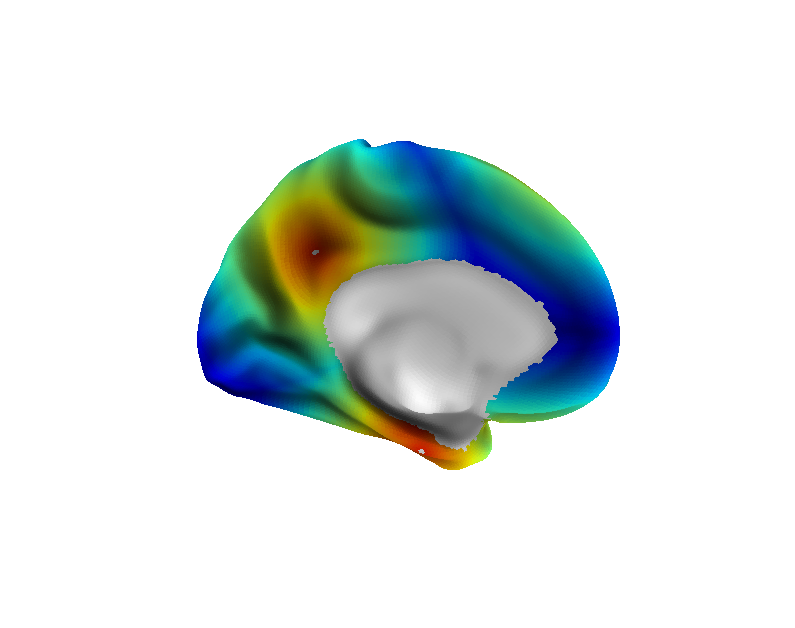

75
7


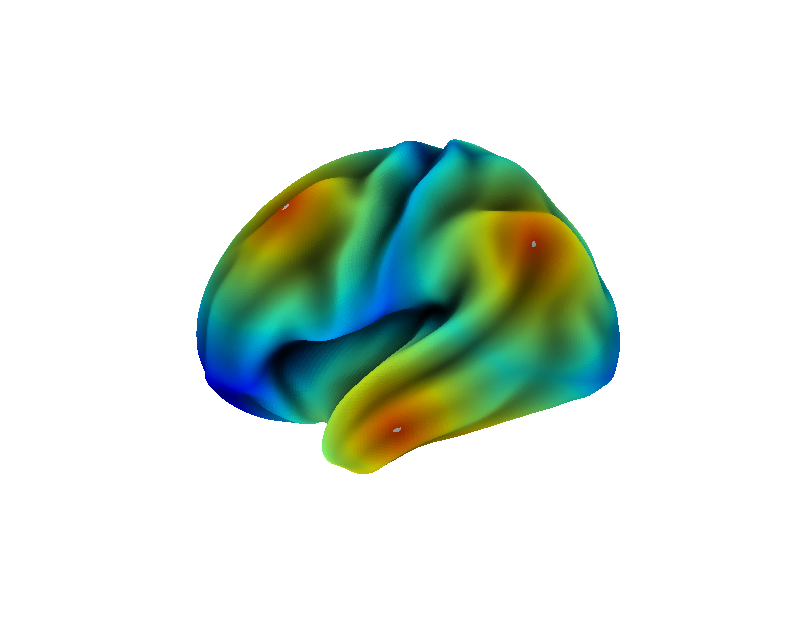

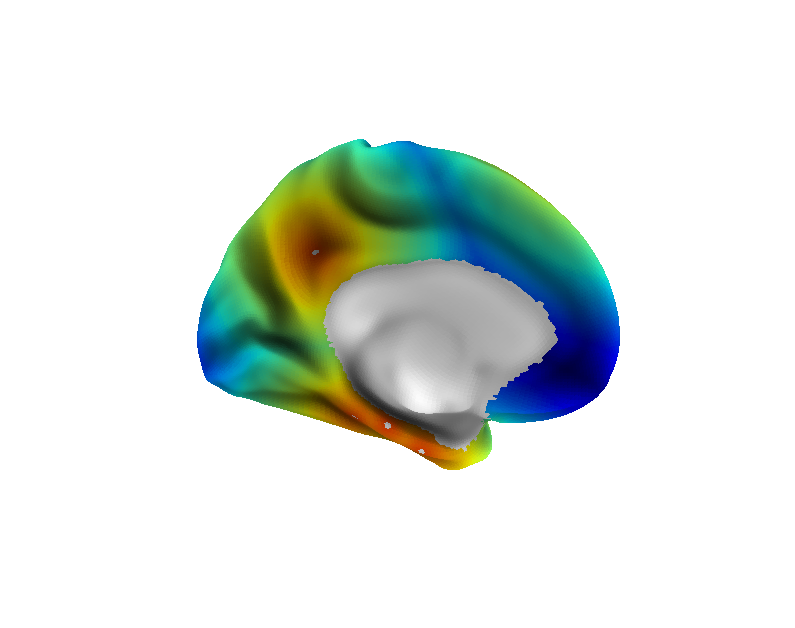

80
6


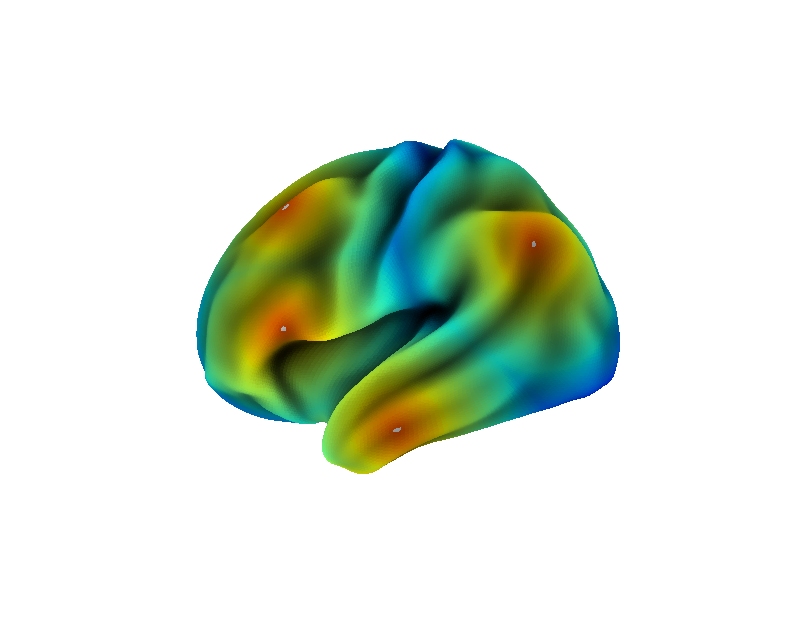

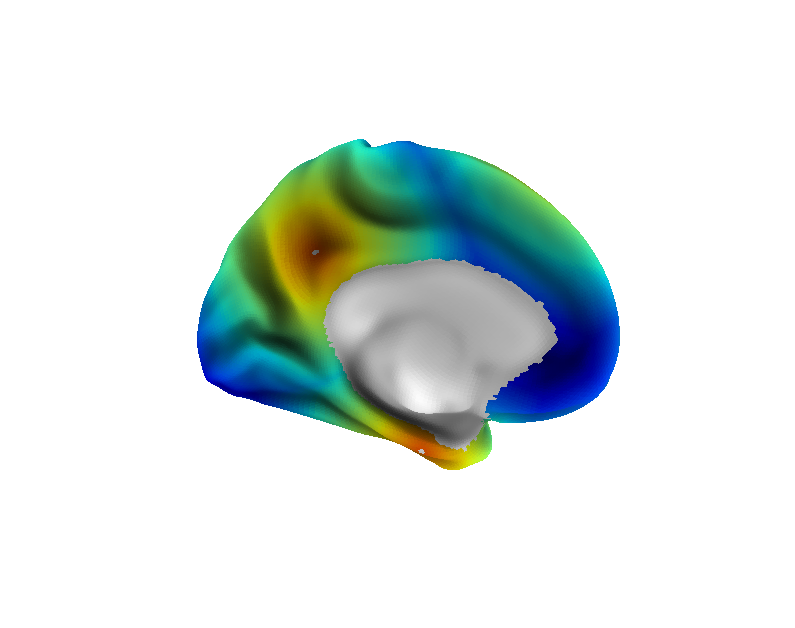

85
12


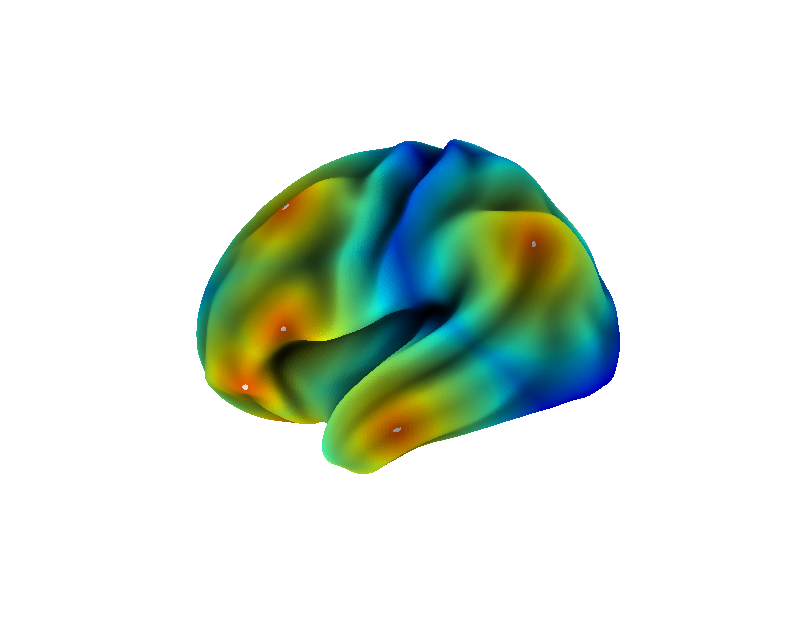

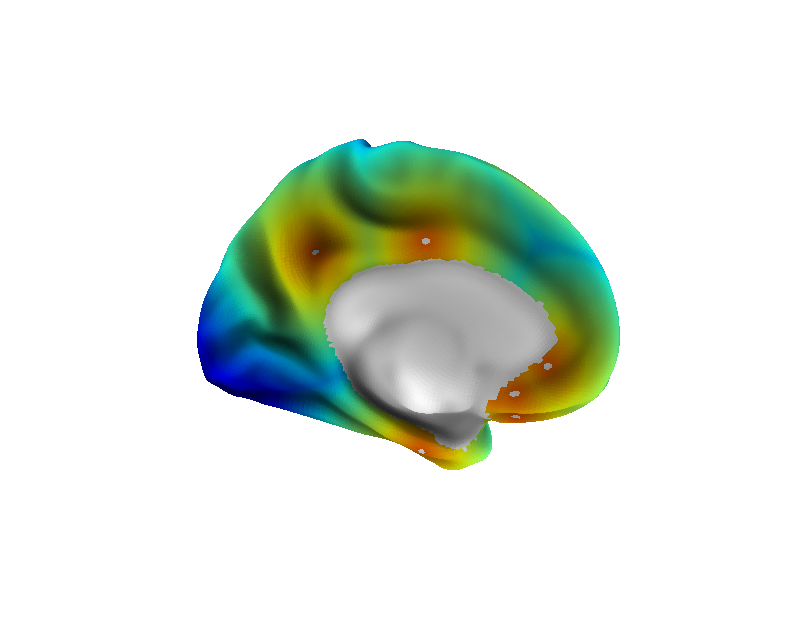

90
10


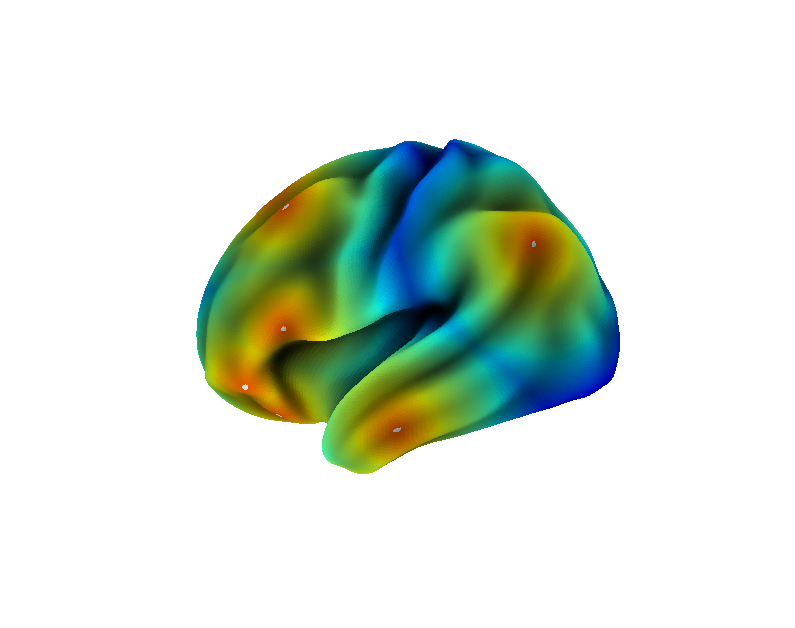

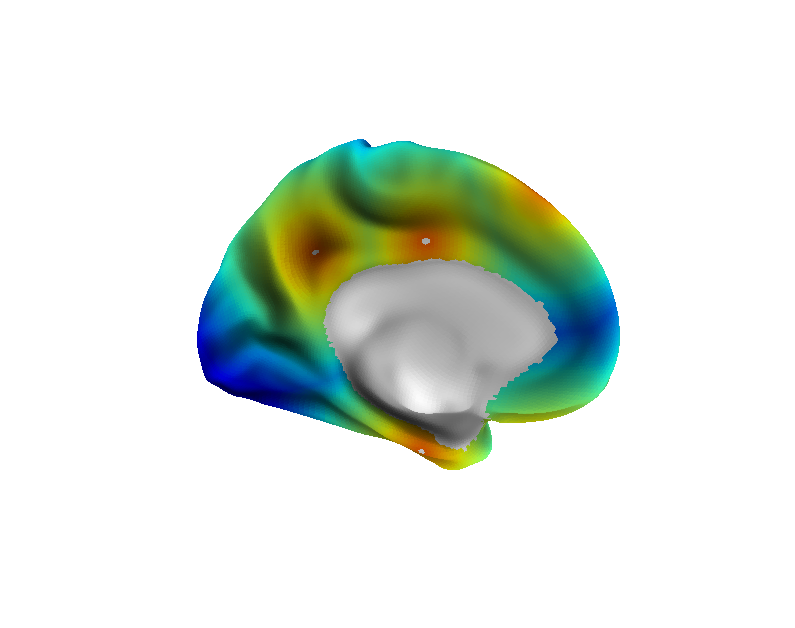

95
14


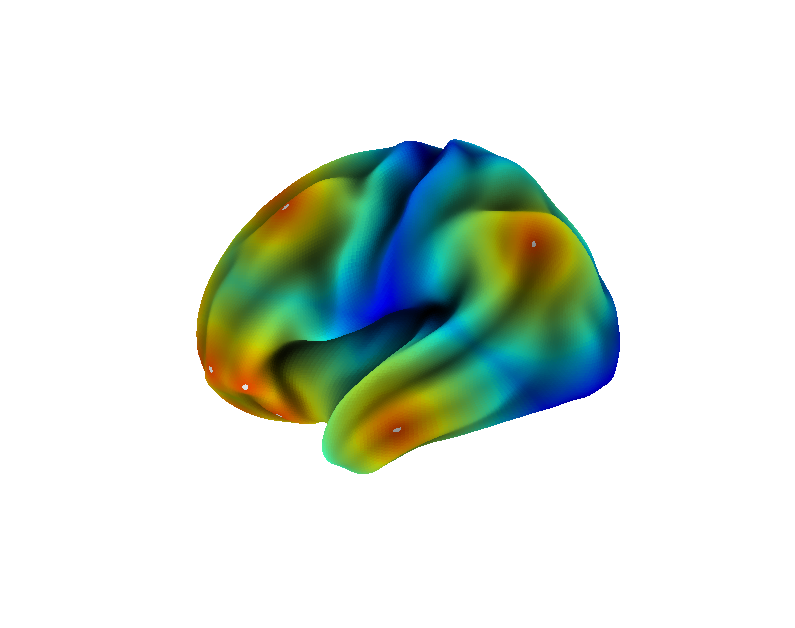

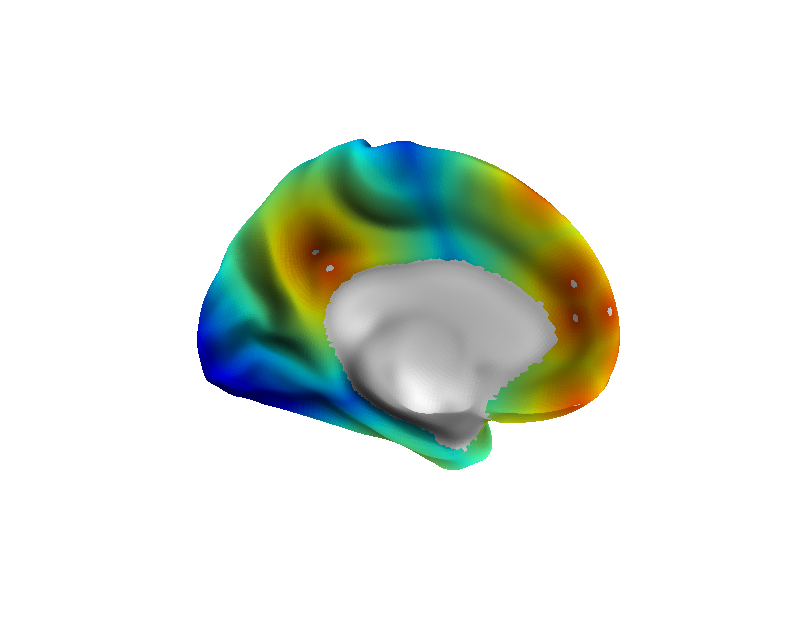

In [33]:
# distance based on peaks:

for perc in [70, 75, 80, 85, 90, 95]:

    print perc
    
    clusts = getClusts(surfL,cortL,perc, emb[:len(cortL),0])

    d = np.zeros(len(surfL[0])) - len(clusts) - 5
    e = np.zeros(len(surfL[0]))
    e[cortL] = emb[:len(cortL),0]
    for i in range(len(clusts)):
        d[clusts[i]] = i + 1
        d[clusts[i][np.argmax(e[clusts[i]])]] = len(clusts) + 5

    pts = np.where(d == len(clusts) + 5)[0]
    distL = surfdist.dist_calc(surfL, np.squeeze(cortL), pts)
    di = distL.copy()
    showSurf((di - np.mean(di)) * -1, surfL, sulcL, np.setdiff1d(cortL, np.where(di == 0)[0]), 
             output_file='gradient_data/figures/dist.%sperc.pts.png' % perc)

In [7]:
ptsL = [21035, 29566, 30472, 11552, 21737, 16444, 13370, 26464]
ptsR = [21034, 29346, 30556, 11533, 21684, 16346, 13332, 26409]
names = ['medial frontal', 'dorsomedial frontal', 'dorsolateral frontal', 
         'ventrolateral frontal', 'lateral temporal', 'inferior parietal', 
         'posteromedial', 'medial temporal']
d = np.abs(np.abs(np.array(surfmL[0][ptsL,:]))-np.abs(np.array(surfmR[0][ptsR,:])))
for n,i in enumerate(d):
    print names[n] + '\t\t %f' % np.sqrt(i[0]**2 + i[1]**2 + i[2]**2)

medial frontal		 2.361335
dorsomedial frontal		 6.952844
dorsolateral frontal		 7.467428
ventrolateral frontal		 1.337740
lateral temporal		 5.977212
inferior parietal		 6.997158
posteromedial		 5.766131
medial temporal		 5.111823


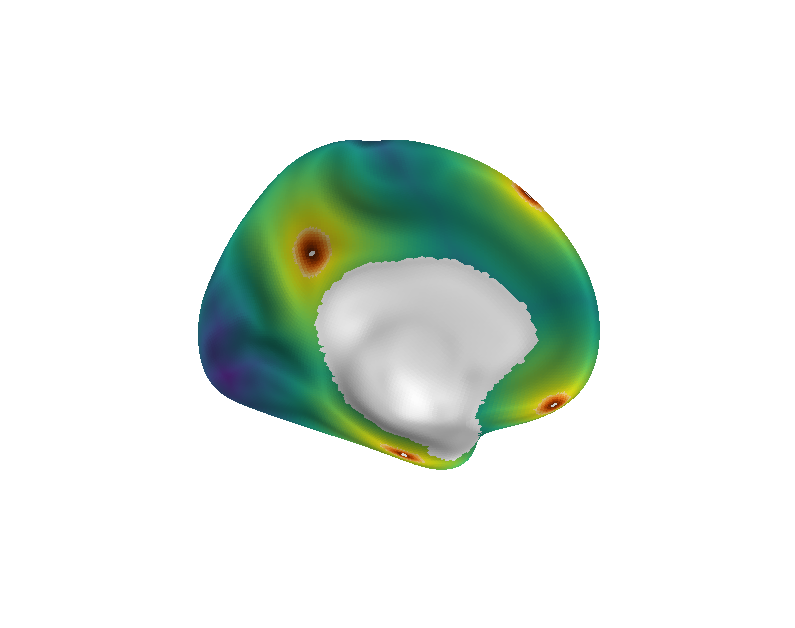

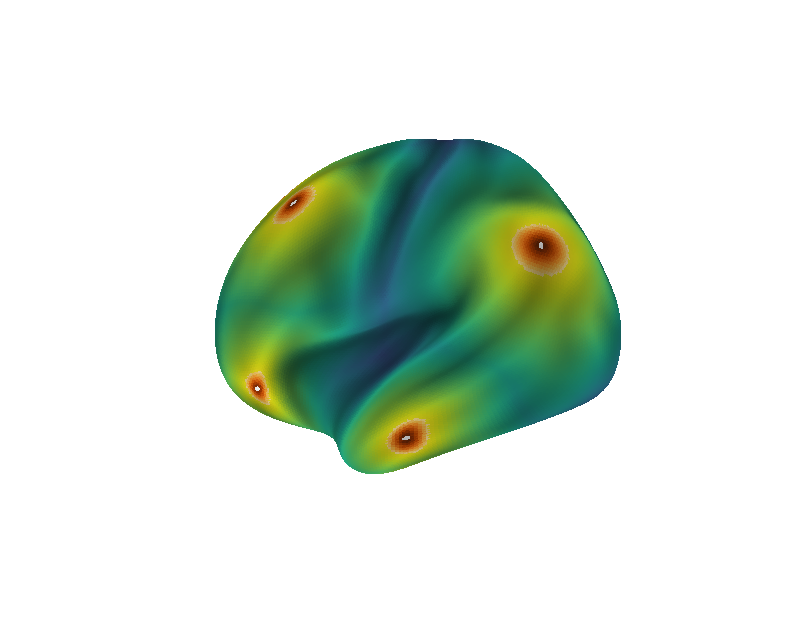

In [8]:
distL = surfdist.dist_calc(surfmL, np.squeeze(cortL), ptsL)
di = distL.copy()
mask = np.setdiff1d(cortL, np.where(di == 0)[0])
di1 = di.copy()
di1[mask] = (di1[mask] - np.mean(di1[mask])) * -1
showSurf(di1, surfiL, sulcL, mask, output_file='gradient_data/figures/embedded/fig.hcp.dist.L', symmetric_cbar = False, cmap=mymap, bg_scaling_factor=1.5)
zoneL = surfdist.zone_calc(surfmL, np.squeeze(cortL), ptsL)
# showSurf(zoneL, surfiL, sulcL, mask, output_file='gradient_data/figures/embedded/fig.hcp.zone.L', symmetric_cbar = False, cmap=mymap, bg_scaling_factor=1.5)

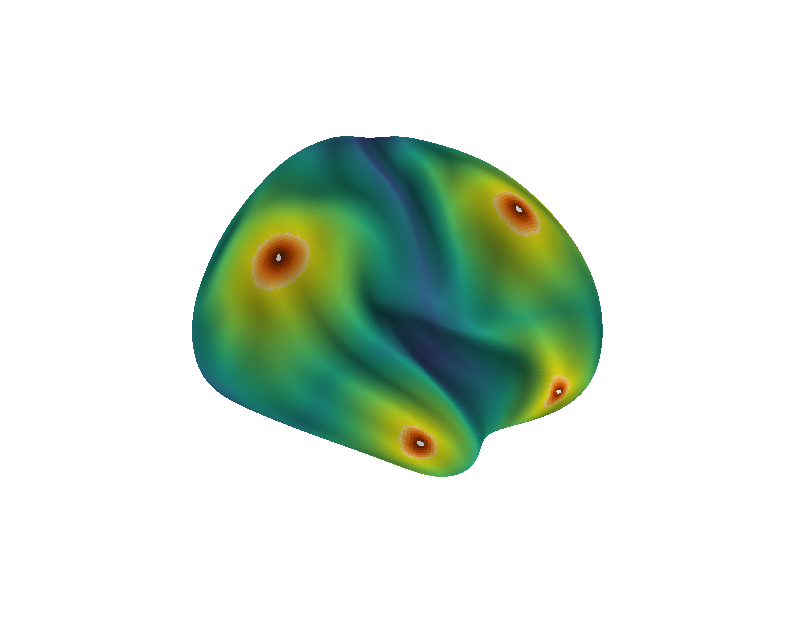

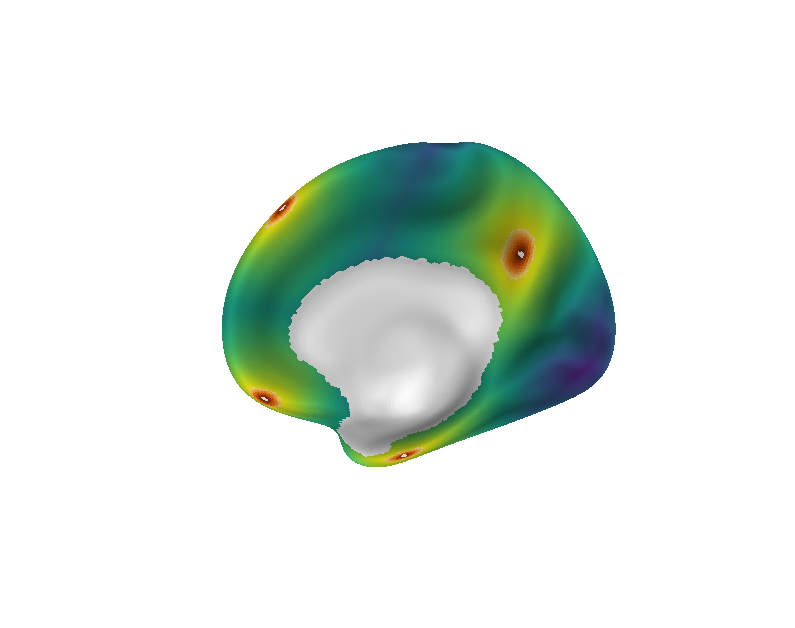

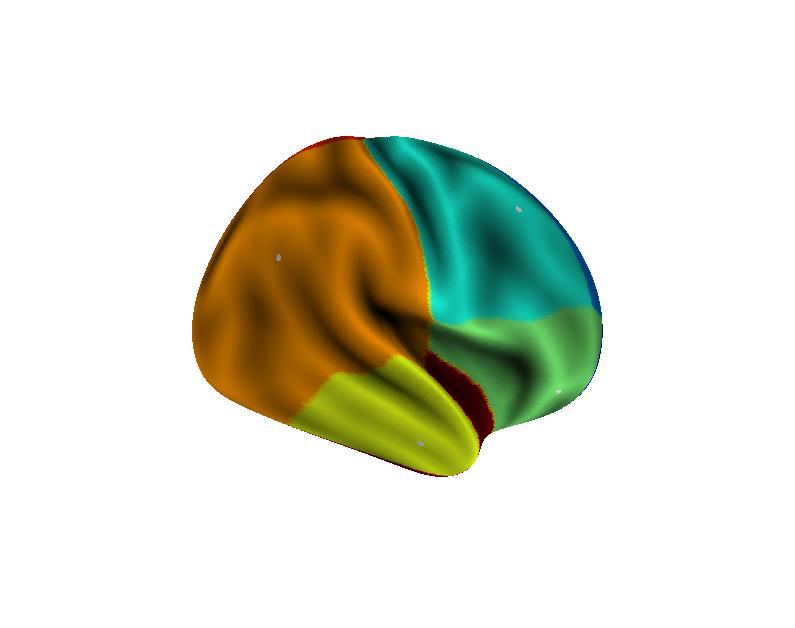

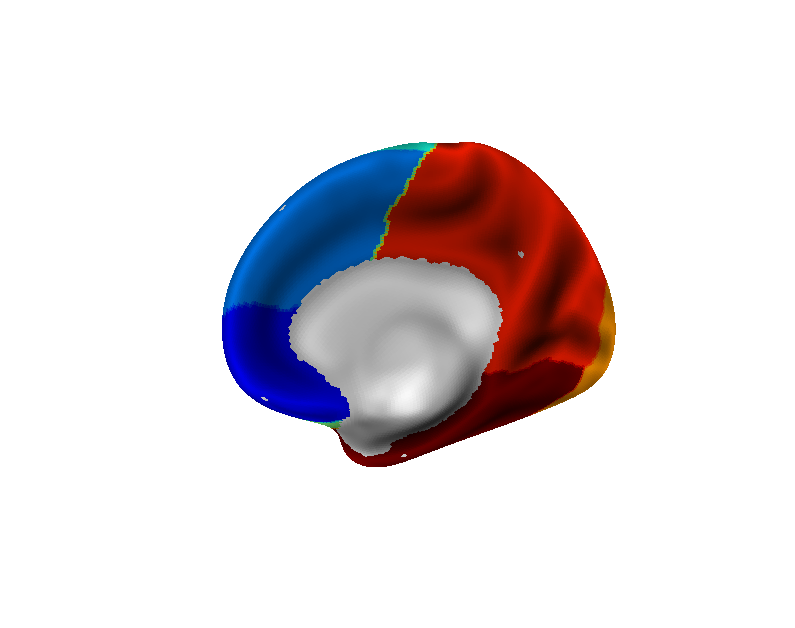

In [9]:
distR = surfdist.dist_calc(surfmL, np.squeeze(cortR), ptsR)
di = distR.copy()
mask = np.setdiff1d(cortR, np.where(di == 0)[0])
di1 = di.copy()
di1[mask] = (di1[mask] - np.mean(di1[mask])) * -1
showSurf(di1, surfiR, sulcR, mask, output_file='gradient_data/figures/embedded/fig.hcp.dist.R', symmetric_cbar = False, cmap=mymap, bg_scaling_factor=1.5)
zoneR = surfdist.zone_calc(surfmR, np.squeeze(cortR), ptsR)
showSurf(zoneR, surfiR, sulcR, mask)

In [10]:
print np.max(distL)
print np.min(distL)
print np.max(distR)
print np.min(distR)

83.7555288127
0.0
80.8957523937
0.0


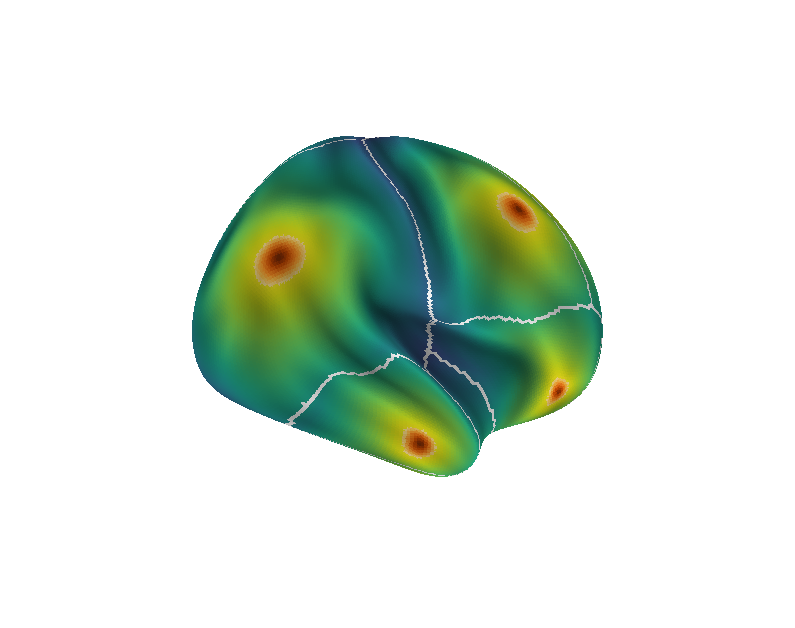

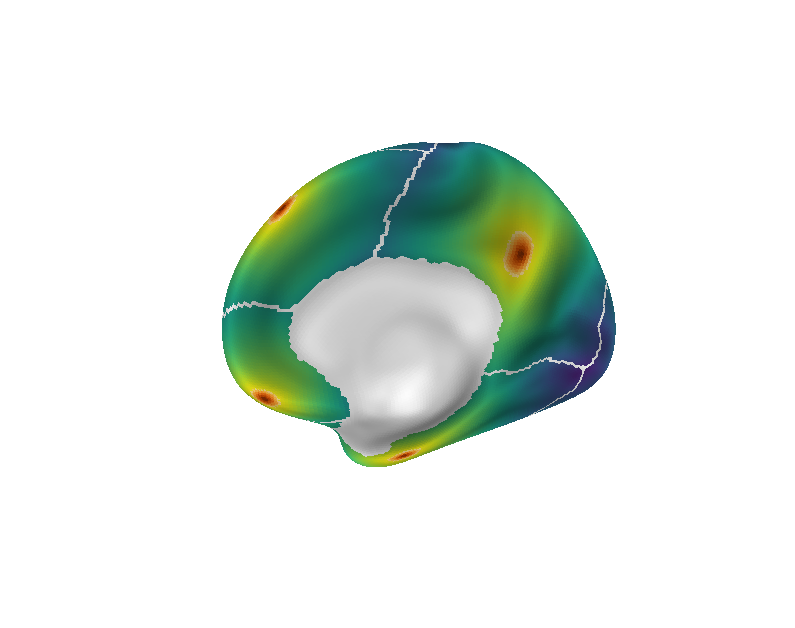

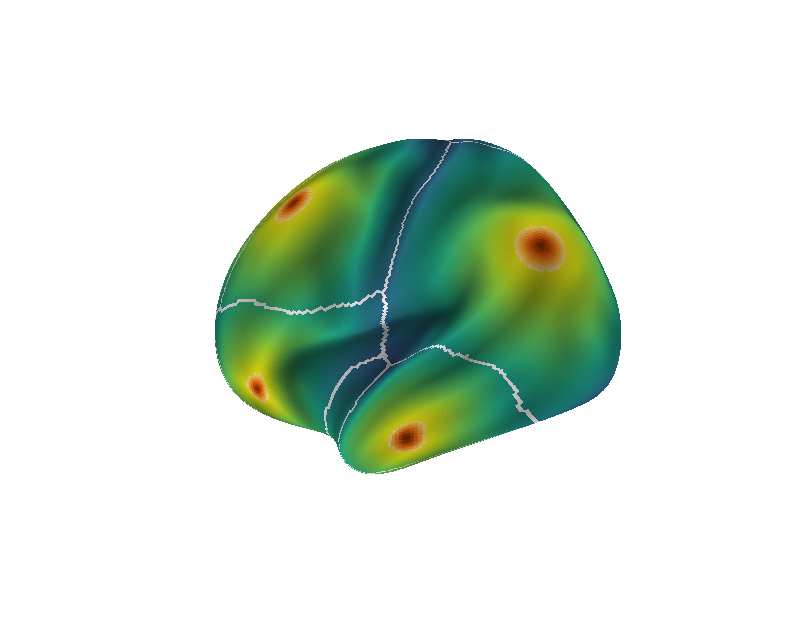

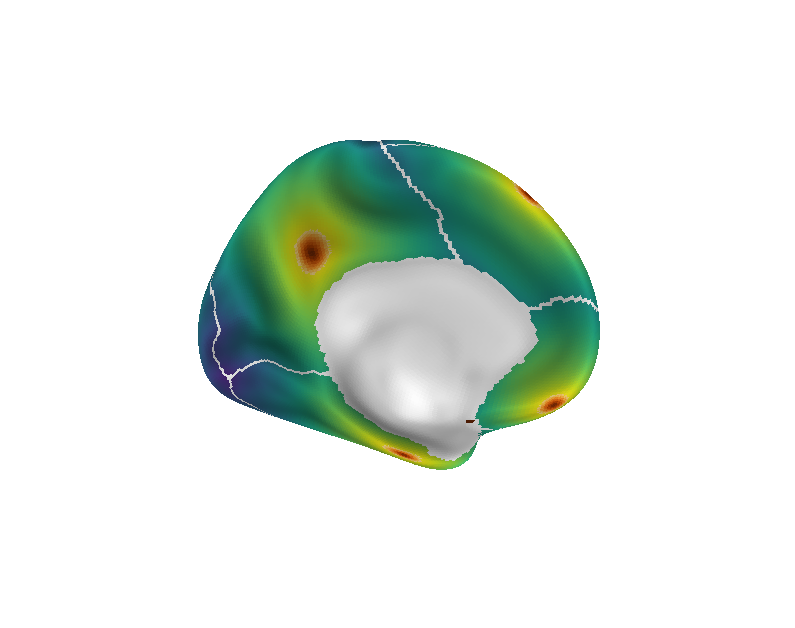

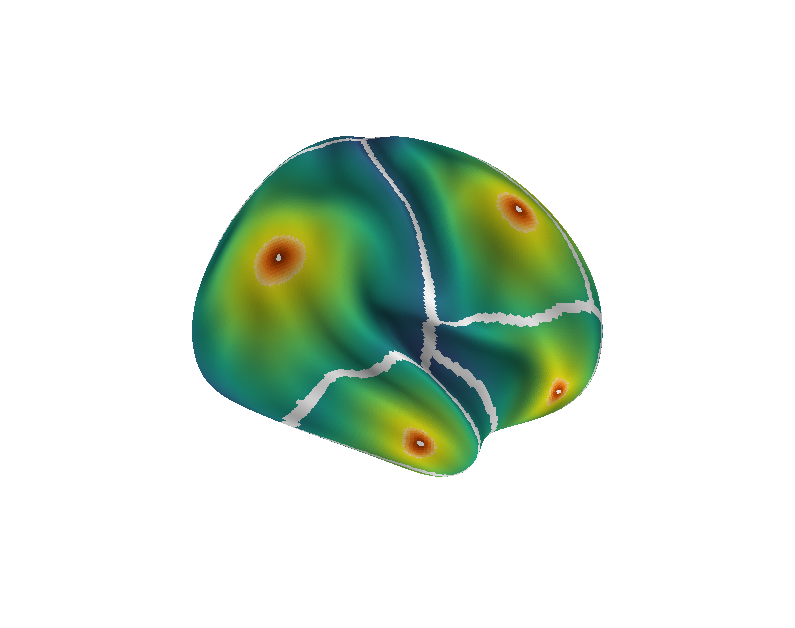

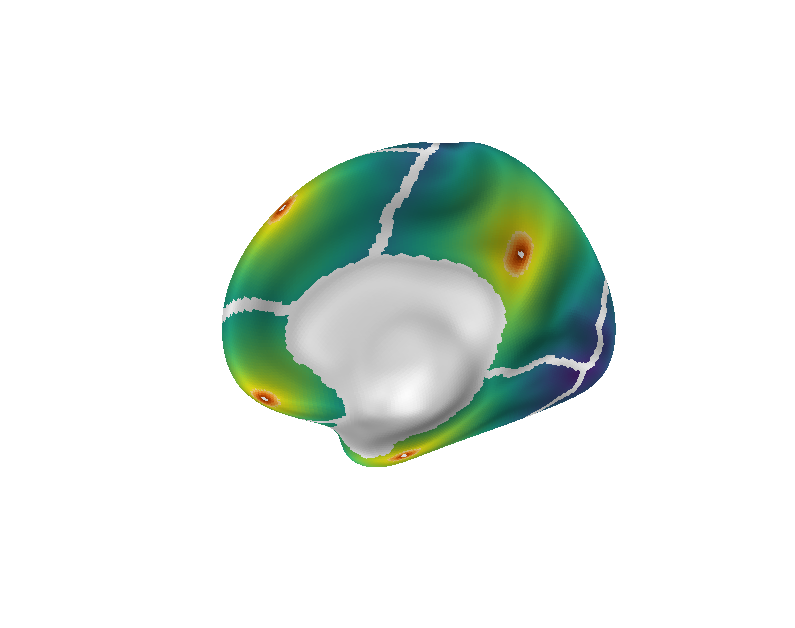

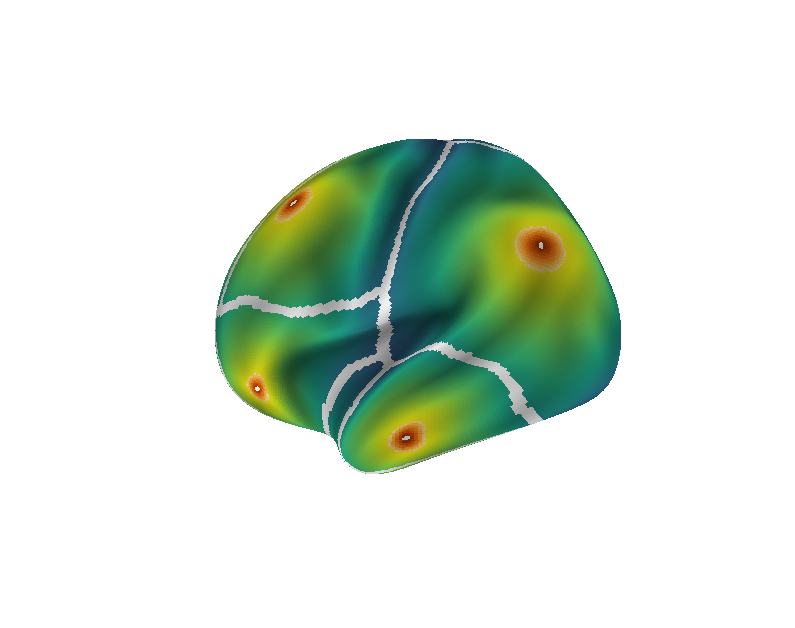

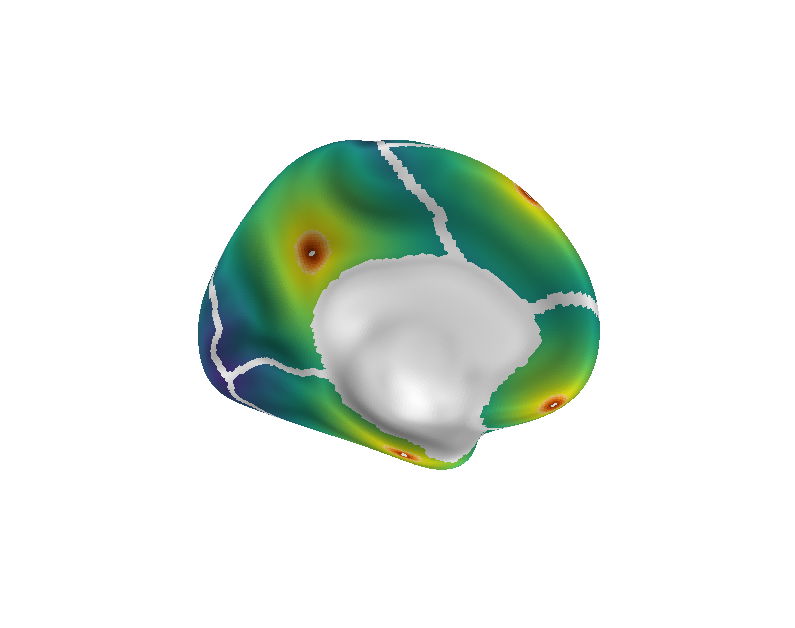

In [11]:
aR = []
z0 = zoneR[surfR[1]][:,0]
z1 = zoneR[surfR[1]][:,1]
z2 = zoneR[surfR[1]][:,2]

for n,i in enumerate(z0):
    if i != z1[n]:
        aR.append(surfR[1][n])
    if i != z2[n]:
        aR.append(surfR[1][n])
    if z1[n] != z2[n]:
        aR.append(surfR[1][n])
aR = np.unique(aR)

aL = []
z0 = zoneL[surfL[1]][:,0]
z1 = zoneL[surfL[1]][:,1]
z2 = zoneL[surfL[1]][:,2]

for n,i in enumerate(z0):
    if i != z1[n]:
        aL.append(surfL[1][n])
    if i != z2[n]:
        aL.append(surfL[1][n])
    if z1[n] != z2[n]:
        aL.append(surfL[1][n])
aL = np.unique(aL)

# Right:
f = plot_surf_stat_map(surfiR[0], surfiR[1], bg_map=sulcR, stat_map=(distR - distR[cortR].mean()) * -1, alpha=1, lenient=True,
                        mask=np.setdiff1d(cortR, np.concatenate((aR, ptsR))), bg_on_stat=True, azim=0, elev=0, symmetric_cbar = False, cmap=mymap, bg_scaling_factor=1.5)
f.savefig('gradient_data/figures/dist.dist.rh.lat.png')
plt.show()
f = plot_surf_stat_map(surfiR[0], surfiR[1], bg_map=sulcR, stat_map=(distR - distR[cortR].mean()) * -1, alpha=1, lenient=True,
                        mask=np.setdiff1d(cortR, np.concatenate((aR, ptsR))), bg_on_stat=True, azim=180, elev=0, symmetric_cbar = False, cmap=mymap, bg_scaling_factor=1.5)
f.savefig('gradient_data/figures/dist.dist.rh.med.png')
plt.show()
# Left:
f = plot_surf_stat_map(surfiL[0], surfiL[1], bg_map=sulcL, stat_map=(distL - distL[cortL].mean()) * -1, alpha=1, lenient=True,
                        mask=np.setdiff1d(cortR, np.concatenate((aL, ptsL))), bg_on_stat=True, azim=180, elev=0, symmetric_cbar = False, cmap=mymap, bg_scaling_factor=1.5)
f.savefig('gradient_data/figures/dist.dist.lh.lat.png')
plt.show()
f = plot_surf_stat_map(surfiL[0], surfiL[1], bg_map=sulcL, stat_map=(distL - distL[cortL].mean()) * -1, alpha=1, lenient=True,
                        mask=np.setdiff1d(cortR, np.concatenate((aL, ptsL))), bg_on_stat=True, azim=0, elev=0, symmetric_cbar = False, cmap=mymap, bg_scaling_factor=1.5)
f.savefig('gradient_data/figures/dist.dist.lh.med.png')
plt.show()
# 

f = plot_surf_stat_map(surfiR[0], surfiR[1], bg_map=sulcR, stat_map=(distR - distR[cortR].mean()) * -1, alpha=1, 
                        mask=np.setdiff1d(cortR, np.concatenate((aR, ptsR))), bg_on_stat=True, azim=0, elev=0, symmetric_cbar = False, cmap=mymap, bg_scaling_factor=1.5)
f.savefig('gradient_data/figures/dist.dist.rh.lat.pts.png')
plt.show()
f = plot_surf_stat_map(surfiR[0], surfiR[1], bg_map=sulcR, stat_map=(distR - distR[cortR].mean()) * -1, alpha=1, 
                        mask=np.setdiff1d(cortR, np.concatenate((aR, ptsR))), bg_on_stat=True, azim=180, elev=0, symmetric_cbar = False, cmap=mymap, bg_scaling_factor=1.5)
f.savefig('gradient_data/figures/dist.dist.rh.med.pts.png')
plt.show()
# Left:
f = plot_surf_stat_map(surfiL[0], surfiL[1], bg_map=sulcL, stat_map=(distL - distL[cortL].mean()) * -1, alpha=1, 
                        mask=np.setdiff1d(cortR, np.concatenate((aL, ptsL))), bg_on_stat=True, azim=180, elev=0, symmetric_cbar = False, cmap=mymap, bg_scaling_factor=1.5)
f.savefig('gradient_data/figures/dist.dist.lh.lat.pts.png')
plt.show()
f = plot_surf_stat_map(surfiL[0], surfiL[1], bg_map=sulcL, stat_map=(distL - distL[cortL].mean()) * -1, alpha=1, 
                        mask=np.setdiff1d(cortR, np.concatenate((aL, ptsL))), bg_on_stat=True, azim=0, elev=0, symmetric_cbar = False, cmap=mymap, bg_scaling_factor=1.5)
f.savefig('gradient_data/figures/dist.dist.lh.med.pts.png')
plt.show()

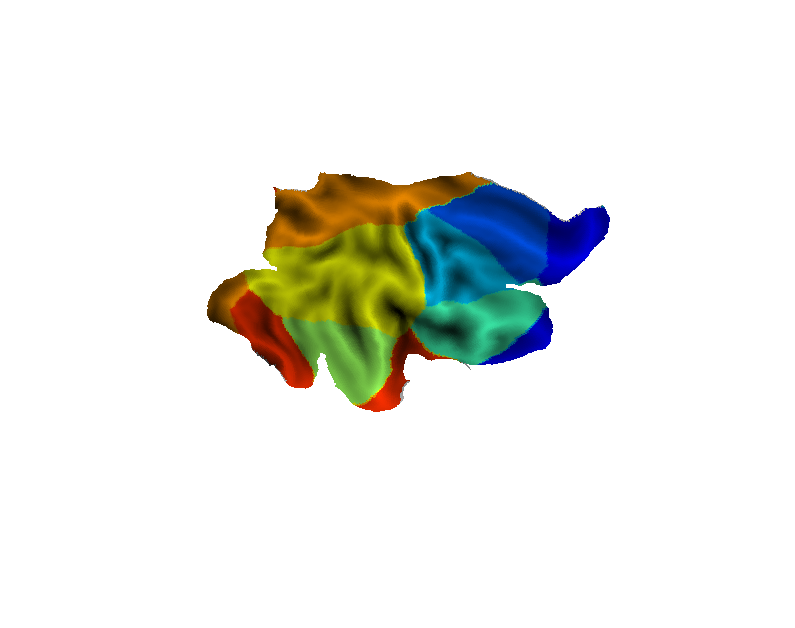

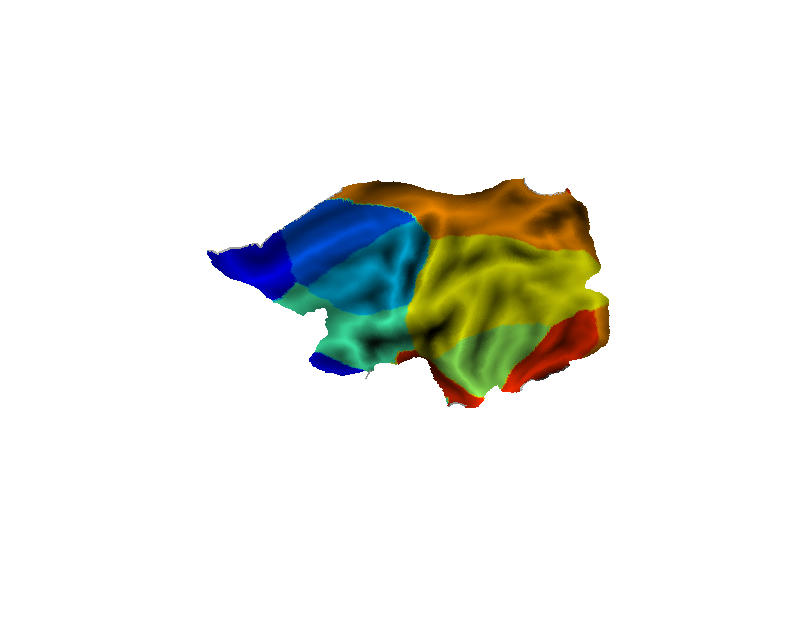

In [267]:
f = plot_surf_stat_map(surffR[0], surffR[1], bg_map=sulcR, stat_map=zoneR - zoneR.mean(), 
                        mask=cortR, bg_on_stat=True, azim=270, elev=90)
plt.show()

f = plot_surf_stat_map(surffL[0], surffL[1], bg_map=sulcL, stat_map=zoneL - zoneL.mean(), 
                        mask=cortL, bg_on_stat=True, azim=270, elev=90)
plt.show()

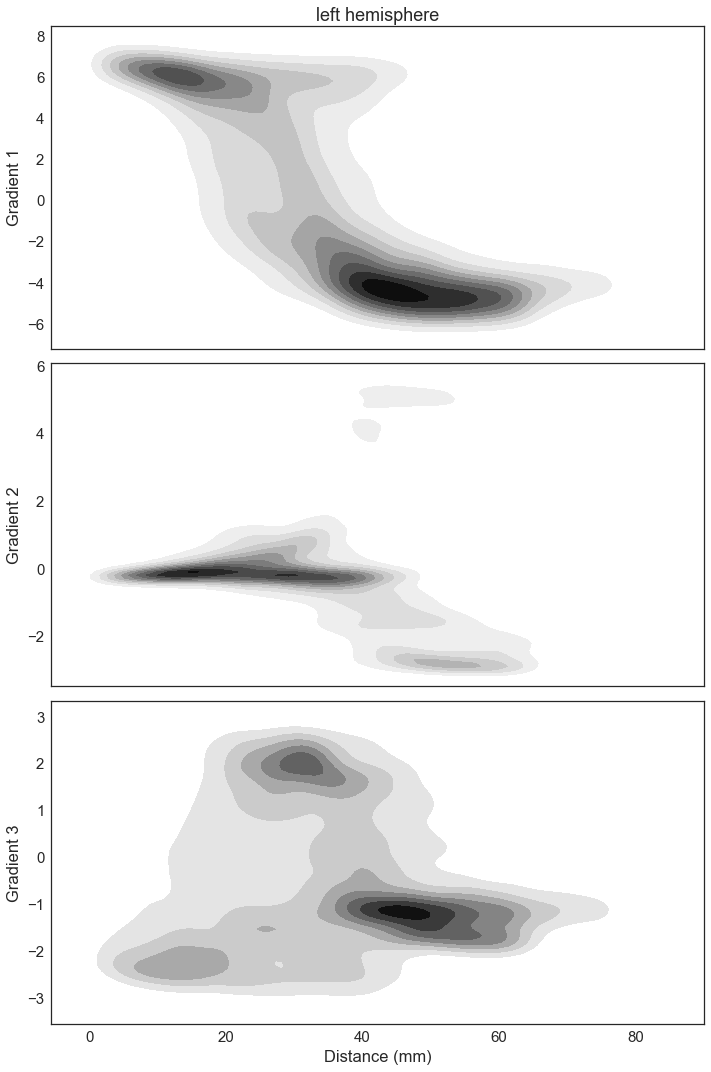

In [347]:
sns.set(style="white")
sns.set_context("notebook", font_scale=1.5)

cortLincld = np.setdiff1d(cortL, np.where(distL == 0)[0])
embl = np.zeros(32492)

f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(10,15))

embl[cortL] = emb[0:len(cortL),0]
sns.kdeplot(distL[cortLincld], embl[cortLincld], hist=False, size=10, legend=True, label='big', 
                 shade=True, shade_lowest=False, linewidth=5, ax=ax1, cmap='Greys')
ax1.set_ylabel('Gradient 1')
ax1.set_title('left hemisphere')

embl[cortL] = emb[0:len(cortL),1]
sns.kdeplot(distL[cortLincld], embl[cortLincld], hist=False, size=10, legend=True, label='big', 
                 shade=True, shade_lowest=False, linewidth=5, ax=ax2, cmap='Greys')
ax2.set_ylabel('Gradient 2')

embl[cortL] = emb[0:len(cortL),2]
sns.kdeplot(distL[cortLincld], embl[cortLincld], hist=False, size=10, legend=True, label='big', 
                 shade=True, shade_lowest=False, linewidth=5, ax=ax3, cmap='Greys')
ax3.set_ylabel('Gradient 3')
ax3.set_xlabel('Distance (mm)')

plt.tight_layout()
plt.show()

f.savefig('gradient_data/figures/dist.pts.scatterplot.contours.all.pdf')
f.savefig('gradient_data/figures/dist.pts.scatterplot.contours.all.png')

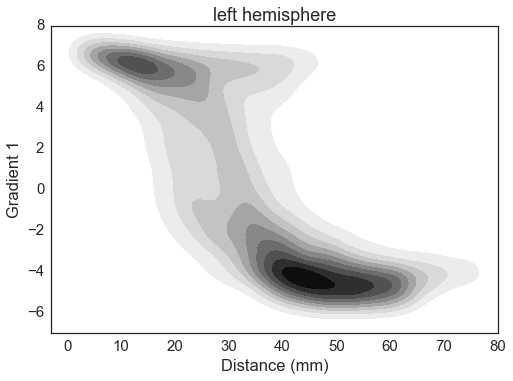

In [307]:
sns.set(style="white")
sns.set_context("notebook", font_scale=1.5)

cortLincld = np.setdiff1d(cortL, np.where(distL == 0)[0])
embl = np.zeros(32492)
embl[cortL] = emb[0:len(cortL),0]

f, ax1 = plt.subplots(1)
sns.kdeplot(distL[cortLincld], embl[cortLincld], hist=False, size=10, legend=True, label='big', 
                 shade=True, shade_lowest=False, linewidth=5, ax=ax1, cmap='Greys')
ax1.set_xlabel('Distance (mm)')
ax1.set_ylabel('Gradient 1')
ax1.set_xlim([-3,80])
ax1.set_ylim([-7,8])
ax1.set_title('left hemisphere')
f.savefig('gradient_data/figures/dist.perc90.scatterplot.contours.pdf')
f.savefig('gradient_data/figures/dist.perc90.scatterplot.contours.png')

/Applications/miniconda3/envs/topography/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


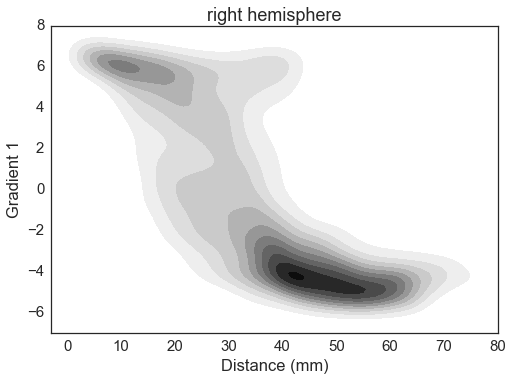

In [308]:
sns.set(style="white")
sns.set_context("notebook", font_scale=1.5)

cortLincld = np.setdiff1d(cortR, np.where(distR == 0)[0])
embl = np.zeros(32492)
embl[cortR] = emb[len(cortL)::,0]

f, ax1 = plt.subplots(1)
sns.kdeplot(distR[cortLincld], embl[cortLincld], hist=False, size=10, legend=True, label='big', 
                 shade=True, shade_lowest=False, linewidth=5, ax=ax1, cmap='Greys')
ax1.set_xlabel('Distance (mm)')
ax1.set_ylabel('Gradient 1')
ax1.set_xlim([-3,80])
ax1.set_ylim([-7,8])
ax1.set_title('right hemisphere')
f.savefig('gradient_data/figures/dist.perc90.scatterplot.contours.rh.pdf')
f.savefig('gradient_data/figures/dist.perc90.scatterplot.contours.rh.png')

## Distance from yeo7 DMN peaks

In [ ]:
sns.set(style="white")
sns.set_context("notebook", font_scale=1.5)

In [ ]:
# Points derived from [include matlab script...]

DMNpeaksL = np.array([13335,28269,16243,29901,32148,20127,21508])-1
DMNpeaksR = np.array([28453,13354,16219,29760,32175,20229,26580])-1

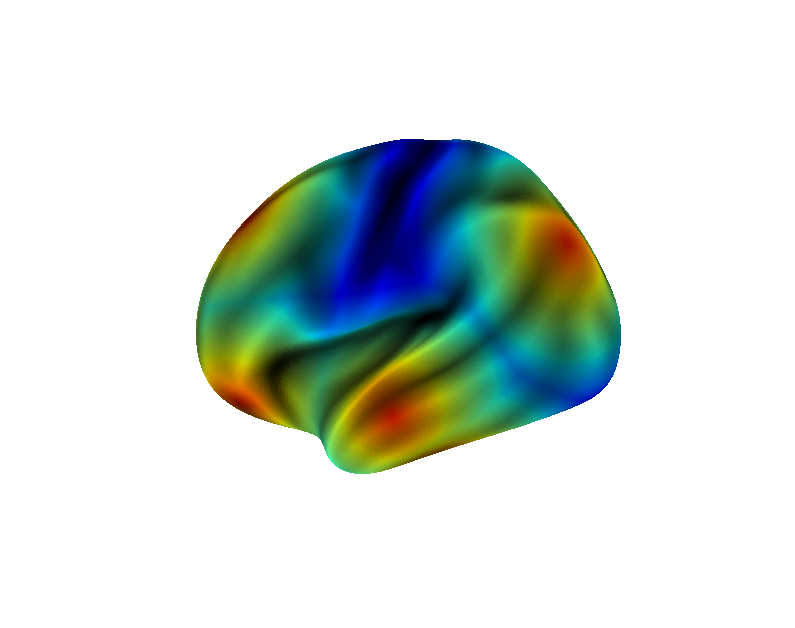

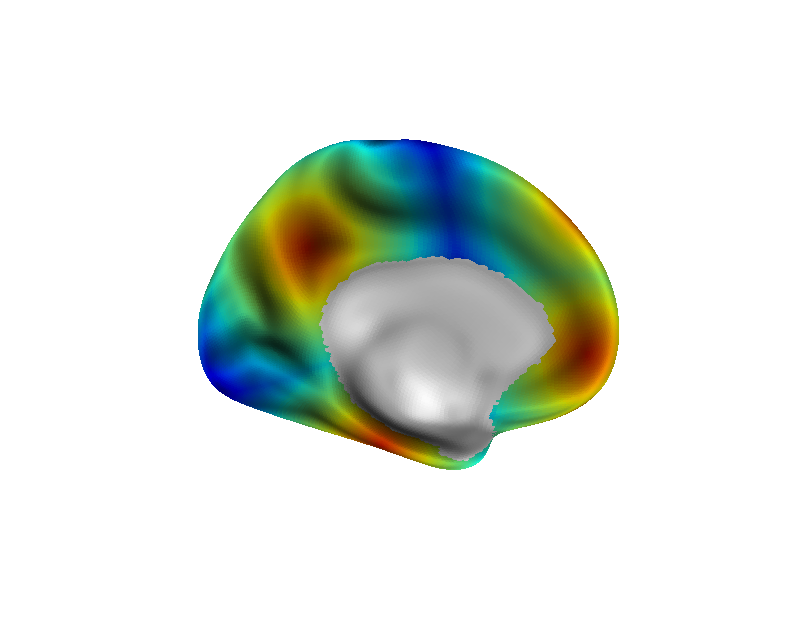

0
1
2
3
4
5
6


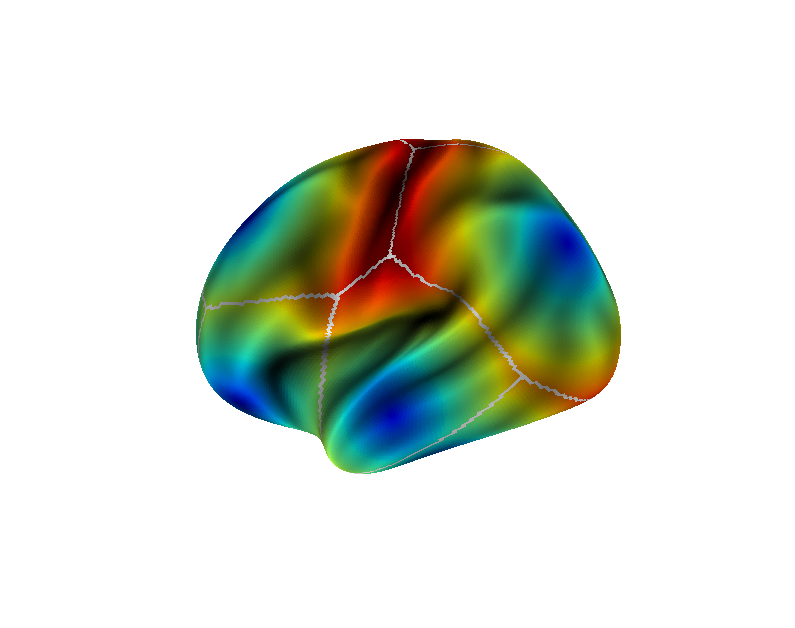

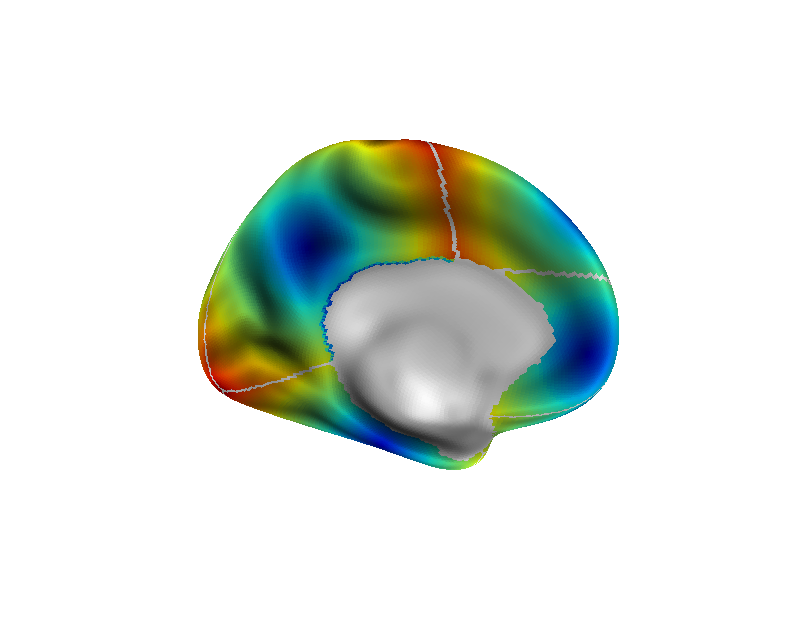

/Applications/miniconda3/envs/topography/lib/python2.7/site-packages/ipykernel/__main__.py:76: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


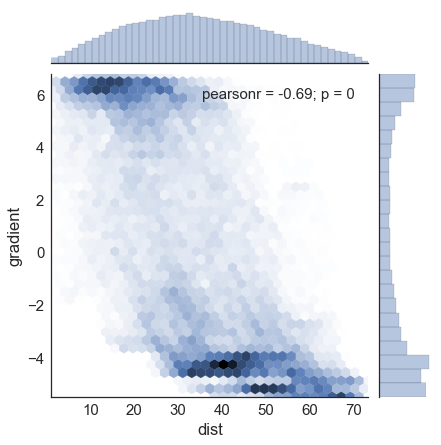

In [14]:
DMNdistL = doDist(DMNpeaksL, surfiL, cortL, sulcL, plotDist=True, zones=True, 
                  plots=emb[0:len(cortL),0])

In [ ]:
DMNdistR = doDist(DMNpeaksR, surfiR, cortR, sulcR, plotDist=True, zones=True, 
                  plots=emb[len(cortL)::,0])

# Macaque distance

In [4]:
import scipy as sp
import scipy.io

atlases = {'rm': 0, 'lv': 1, 'fv': 3, 'b05': 4, 'bb47': 5, 'pht00': 7}

mat = sp.io.loadmat('gradient_data/macaque/f99_vertices_faces.mat')
surf = []
surf.append(np.array(mat['vertices'], dtype=np.float64))
surf.append(np.array(mat['faces'] - 1, dtype=np.int32))
sulc = nib.freesurfer.read_morph_data('gradient_data/macaque/rh.sulc') * -1
nodes = pd.read_csv('gradient_data/macaque/nodes_areaids.txt', '\t', header=-1)

mask = []
for x in xrange(0,len(surf[0])):
    mask.append(np.count_nonzero(nodes.T[x]))    
cort = np.squeeze(np.sort(np.where(np.array(mask) > 1)))
cort = np.array(cort, dtype=np.int32)

vertices, triangles = utils.surf_keep_cortex(surf, cort)

In [7]:
import gdist 

# distMacacque(ids[range(24)], 'fv')
def distMacacque(num, alt):
    '''
    num = [280, 352, 302]
    alt = 'fv'
    '''
    src_label = []
    dist_vals = np.zeros((len(num), len(cort)))
    for n in xrange(0,len(num)):
        src = utils.translate_src(np.squeeze(np.where(nodes[atlases.get(alt)] == num[n])), cort)
        src_label.append(np.squeeze(np.where(nodes[atlases.get(alt)] == num[n])))
        dist_vals[n, :] = gdist.compute_gdist(vertices, triangles, source_indices=np.array(src, dtype=np.int32))
        del src    
    
    src_label = np.concatenate(src_label)
    src_label_cort = np.zeros(len(surf[0]))
    src_label_cort[src_label] = 1
    plot_surf_stat_map(surf[0], surf[1], bg_map=sulc, stat_map=src_label_cort, 
                       mask=np.where(src_label_cort != 0.)[0], 
                       bg_on_stat=True, azim=0, label=True, lenient=True)
    plt.show()
    plot_surf_stat_map(surf[0], surf[1], bg_map=sulc, stat_map=src_label_cort, 
                       mask=np.where(src_label_cort != 0.)[0], 
                       bg_on_stat=True, azim=180, label=True, lenient=True)
    plt.show()
        
    zone = utils.recort((np.argsort(dist_vals, axis=0)[0, :] + 1.) / len(num), surf, cort)
    plot_surf_stat_map(surf[0], surf[1], bg_map=sulc, stat_map=zone, 
                       mask=np.where(zone != 0.)[0], 
                       bg_on_stat=True, azim=0, label=True, lenient=True)
    plt.show()
    plot_surf_stat_map(surf[0], surf[1], bg_map=sulc, stat_map=zone, 
                       mask=np.where(zone != 0.)[0], 
                       bg_on_stat=True, azim=180, label=True, lenient=True)
    plt.show()

    dist = utils.recort(np.sort(dist_vals, axis=0)[0, :], surf, cort)
    dret = dist.copy()
    
    print np.max(dist[np.isfinite(dist)])
    dist = dist - np.mean(dist[np.isfinite(dist)])
    f = plot_surf_stat_map(surf[0], surf[1], bg_map=sulc, stat_map=dist * -1, 
                       mask=np.where(zone != 0.)[0],
                       bg_on_stat=True, azim=0, label=True, lenient=True, symmetric_cbar = False, cmap=mymap)
    fname = 'gradient_data/figures/fig.macaque.dist.lat.png'
    f.savefig(fname, format='png', dpi=600, transparent=False)
    imageCrop(fname)  
    plt.show()
    f = plot_surf_stat_map(surf[0], surf[1], bg_map=sulc, stat_map=dist * -1, 
                       mask=np.where(zone != 0.)[0],
                       bg_on_stat=True, azim=180, label=True, lenient=True, symmetric_cbar = False, cmap=mymap)
    fname = 'gradient_data/figures/fig.macaque.dist.med.png'
    f.savefig(fname, format='png', dpi=600, transparent=False)
    imageCrop(fname)  
    plt.show()
    
    return dret

def getIds(mat_name, names):
    
    lex = pd.read_csv('gradient_data/macaque/ids_areas.txt', ' ', header=-1)[1]

    ids = np.zeros(len(names))
    for i,y in enumerate(names):
        for n,x in enumerate(lex):
            if x == y:
                ids[i] = n
    return ids

def visDistMacaque(mat_name, ids_num, reverse=False):
        
    emb = np.load('gradient_data/conn_matrices/macaque_%s_emb.npy' % mat_name)
    names = np.load('gradient_data/conn_matrices/macaque_%s_names.npy' % mat_name)
    ids = getIds(mat_name, names)
    s = np.argsort(emb[:,0])
    ids = ids[s].copy()
    # dist_m, cort_ind = distMacacque(ids[len(ids)-4:len(ids)], mat_name)
    # print len(ids)
    if reverse==True:
        ids_num1 = range(len(ids)-ids_num,len(ids))
    else:
        ids_num1 = range(0,ids_num)
        
    dist_m = distMacacque(ids[ids_num1], mat_name)
    
    return dist_m, emb, names

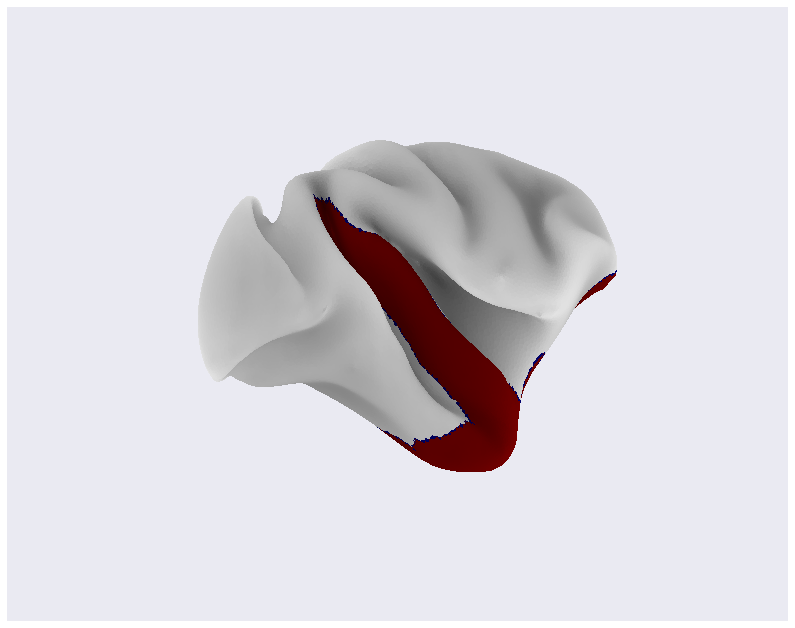

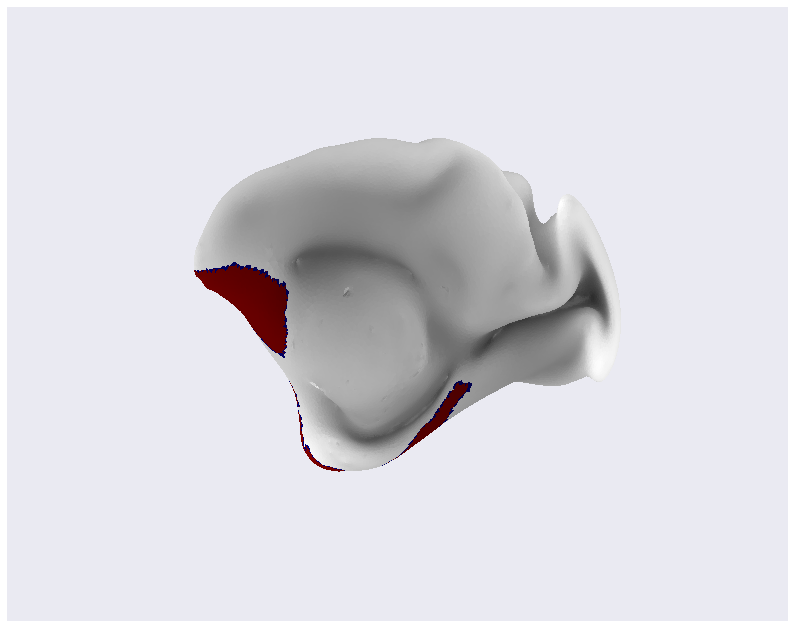

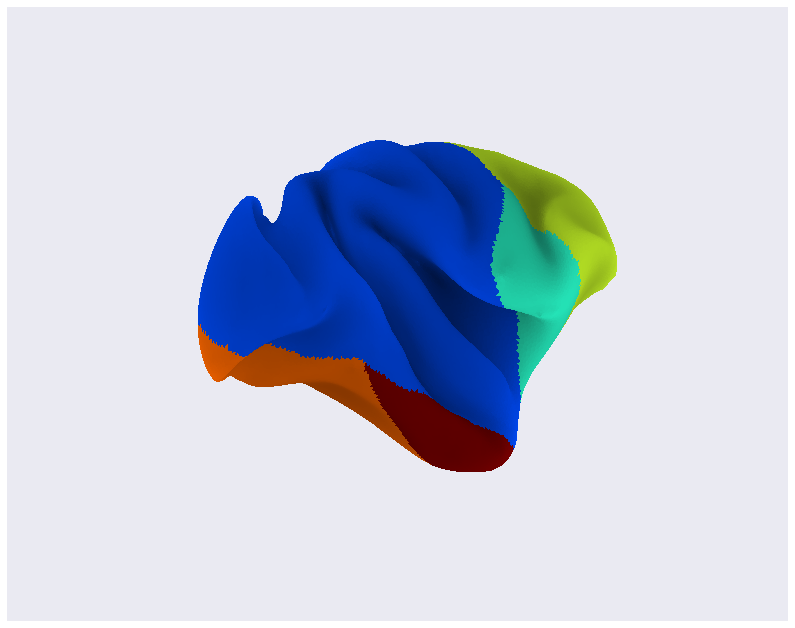

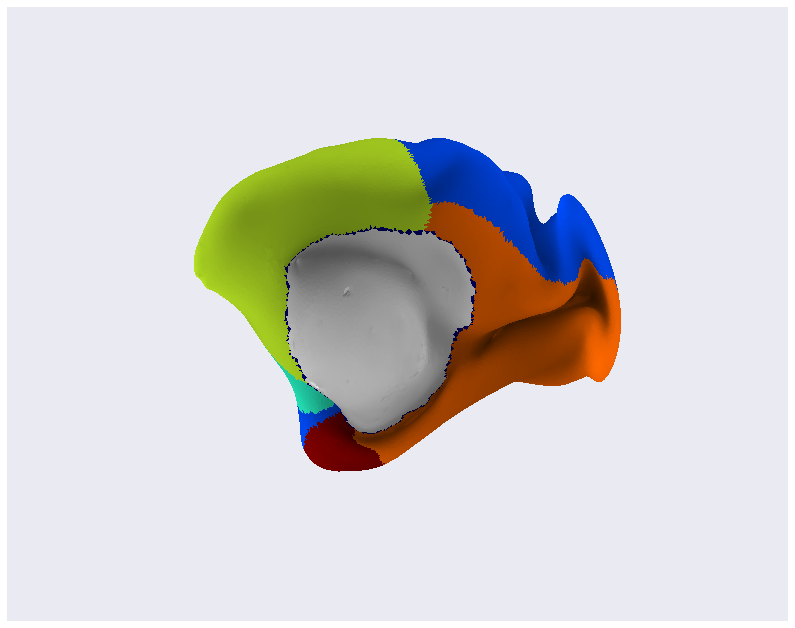

46.8107743764


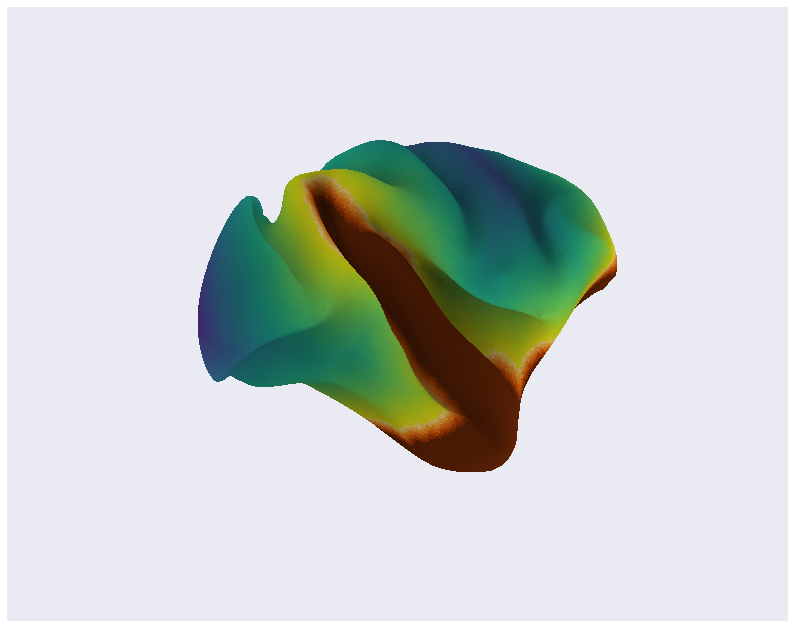

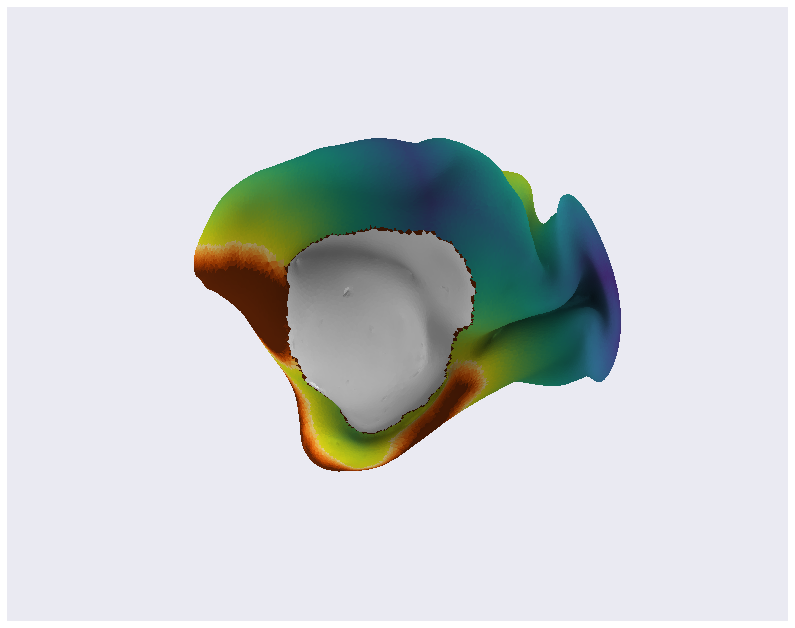

In [8]:
mat_name = 'bb47'
dist_m, emb, names = visDistMacaque(mat_name, 5, reverse=True)

## Macaque distance / embedding scatterplot

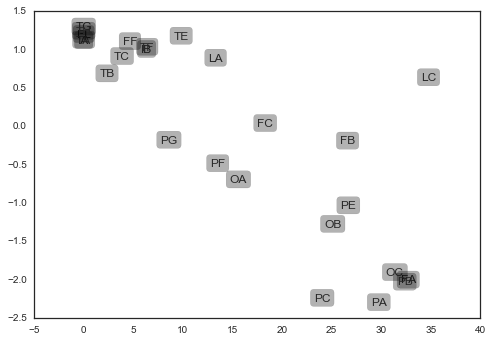

In [23]:
dist_clusts = []
names = np.load('gradient_data/conn_matrices/macaque_%s_names.npy' % mat_name)
ids = getIds(mat_name, names)
emb = np.load('gradient_data/conn_matrices/macaque_%s_emb.npy' % mat_name)
s = np.argsort(emb[:,0])
ids = ids[s].copy()
for n in ids:
    dist_all = dist_m[np.where(nodes[atlases.get(mat_name)] == n)[0]]
    dist_all = dist_all[np.where(np.isfinite(dist_all))[0]]
    dist_clusts.append(np.mean(dist_all))
#print dist_clusts
#dist_clusts[np.where(np.isinf(dist_clusts))[0]]  = 0.

sns.set(style="white")
plt.figure(facecolor="white")

indx = np.argsort(np.argsort(emb[:,0] ))
plt.scatter(np.array(dist_clusts)[indx], emb[:,0], c='white', alpha=0)

labels = names.copy()
for label, x, y, n in zip(labels, np.array(dist_clusts)[indx], emb[:,0], xrange(len(labels))):
    plt.annotate(
        label[12::], 
        xy = (x, y), xytext = (0, 0),
        textcoords = 'offset points', ha = 'center', va = 'center', 
        bbox = dict(boxstyle = 'round,pad=.3', fc = 'black', alpha = 0.3), fontsize=12)

plt.savefig('gradient_data/figures/macaque_plot_comps_dist_%s.pdf' % mat_name)
plt.show()